# Prepare tensorflow-model-optimization for pruning

In [1]:
! pip uninstall -y tensorflow
! pip uninstall -y tf-nightly
! pip install -U tensorflow-gpu==1.14.0

! pip install tensorflow-model-optimization

Uninstalling tensorflow-1.15.0:
  Successfully uninstalled tensorflow-1.15.0
     |████████████████████████████████| 377.0MB 42kB/s 
     |████████████████████████████████| 3.2MB 57.1MB/s 
     |████████████████████████████████| 491kB 68.5MB/s 
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
     |████████████████████████████████| 102kB 3.4MB/s 


In [2]:
%load_ext tensorboard
import tensorboard
import tensorflow as tf
tf.enable_eager_execution()

import tempfile
import zipfile
import os

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


#Download dataset from Google Drive

In [3]:
!pip install PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#https://drive.google.com/open?id=1swPiOWtQ80zWHOK0pyWDuhilhRDkFux8/view?usp=sharing
#https://drive.google.com/open?id=1swPiOWtQ80zWHOK0pyWDuhilhRDkFux8
download = drive.CreateFile({'id': '1swPiOWtQ80zWHOK0pyWDuhilhRDkFux8'})
download.GetContentFile('weed_dataset_w25.hdf5')

# Read Dataset

In [0]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
from operator import truediv
import h5py
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, cohen_kappa_score, confusion_matrix

import tensorboard
import tensorflow as tf
tf.enable_eager_execution()

import tempfile
import zipfile
import os


In [5]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
LOAD HDF5 FILE
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

hdf5_file = h5py.File('weed_dataset_w25.hdf5', "r")
train_x = np.array(hdf5_file["train_img"][...])
# train_x = train_x / np.max(train_x)
# train_x = np.clip(train_x, 0, 1)
#train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], train_x.shape[2], train_x.shape[3], 1))
train_y = np.array(hdf5_file["train_labels"][...])

# Average consecutive bands
img2 = np.zeros((train_x.shape[0], train_x.shape[1], train_x.shape[2], int(train_x.shape[3]/2)))
for n in range(0, train_x.shape[0]):
    # Average consecutive bands
    for i in range(0, train_x.shape[3], 2):
        img2[n, :, :, int(i/2)] = (train_x[n, :, :, i] + train_x[n, :, :, i + 1]) / 2.

train_x = img2

print(train_x.shape)
train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], train_x.shape[2], train_x.shape[3], 1))

(6316, 25, 25, 150)


In [6]:
train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], train_x.shape[2], train_x.shape[3]))

temp = np.zeros((train_x.shape[0], train_x.shape[1], train_x.shape[2], 6))

#temp[:, :, :, 0] = train_x[:, :, :, 2]
#temp[:, :, :, 0] = train_x[:, :, :, 9] 
temp[:, :, :, 0] = train_x[:, :, :, 10] 
temp[:, :, :, 1] = train_x[:, :, :,20] 
#temp[:, :, :, 4] = train_x[:, :, :, 37]
#temp[:, :, :,5] = train_x[:, :, :, 43]
#temp[:, :, :,2] = train_x[:, :, :,55]
#temp[:, :, :,3] = train_x[:, :, :, 66]
#temp[:, :, :,4] = train_x[:, :, :, 101]
#temp[:, :, :, 9] = train_x[:, :, :, 105]
temp[:, :, :, 2] = train_x[:, :, :, 36]  
#temp[:, :, :, 11] = train_x[:, :, :, 107]
#temp[:, :, :, 12] = train_x[:, :, :, 111]
temp[:, :, :, 3] = train_x[:, :, :, 66] 
#temp[:, :, :, 14] = train_x[:, :, :, 114]
#temp[:, :, :, 7] = train_x[:, :, :, 121]
#temp[:, :, :, 16] = train_x[:, :, :, 122]
temp[:, :, :, 4] = train_x[:, :, :, 136] 
#temp[:, :, :, 18] = train_x[:, :, :, 132]
temp[:, :, :, 5] = train_x[:, :, :, 144]
train_x = temp

print(train_x.shape)

(6316, 25, 25, 6)


# Trained pruned network

In [7]:
data = 'WEED'
loaded_model = tf.keras.models.load_model("selected5-weights-hyper3dnet" + data + str(1) + "-best_3layers_4filters.h5")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
from tensorflow_model_optimization.sparsity import keras as sparsity

epochs = 10
batch_size = 64;
num_train_samples = train_x.shape[0]
end_step = np.ceil(1.0 * num_train_samples / batch_size).astype(np.int32) * epochs
print(end_step)

new_pruning_params = {
      'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.01,
                                                   final_sparsity=0.05,
                                                   begin_step=0,
                                                   end_step=end_step,
                                                   frequency=100)
}

new_pruned_model = sparsity.prune_low_magnitude(loaded_model, **new_pruning_params)
new_pruned_model.summary()

new_pruned_model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer='adadelta',
    metrics=['accuracy'])

990
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 25, 25, 6)]       0         
_________________________________________________________________
prune_low_magnitude_separabl (None, 25, 25, 128)       1816      
_________________________________________________________________
prune_low_magnitude_batch_no (None, 25, 25, 128)       513       
_________________________________________________________________
prune_low_magnitude_activati (None, 25, 25, 128)       1         
_________________________________________________________________
prune_low_magnitude_separabl (None, 13, 13, 256)       66946     
_________________________________________________________________
prune_low_magnitude_batch_no (None, 13, 13, 256)       1025      
_________________________________________________________________
prune_low_magnitude_activati (None, 13, 13, 256)       

In [11]:

windowSize = train_x.shape[1]
classes = 3
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
cvoa = []
cvaa = []
cvka = []
cvpre = []
cvrec = []
cvf1 = []
cva1 = []
cva2 = []
cva3 = []

epochs = 10

data = 'WEED'
ntrain = 1
for train, test in kfold.split(train_x, train_y):

    ytrain = tf.keras.utils.to_categorical(train_y[train]).astype(np.int32)
    ytest = tf.keras.utils.to_categorical(train_y[test]).astype(np.int32)

    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    PRUNING
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    new_pruning_params = {
          'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.01,
                                                      final_sparsity=0.03,
                                                      begin_step=0,
                                                      end_step=end_step,
                                                      frequency=100)
    }

    loaded_model.load_weights("selected5-weights-hyper3dnet" + data + str(ntrain) + "-best_3layers_4filters.h5")

    new_pruned_model = sparsity.prune_low_magnitude(loaded_model, **new_pruning_params)
    #new_pruned_model.summary()

    new_pruned_model.compile(
        loss=tf.keras.losses.categorical_crossentropy,
        optimizer='adadelta',
        metrics=['accuracy'])
    
    # checkpoint
    filepath = "pruned5-weights-hyper3dnet" + data + str(ntrain) + "-best_3layers_4filters.h5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint, sparsity.UpdatePruningStep()]

    # Train model on dataset
    print(data + ": Training" + str(ntrain) + "begins...")
    history = new_pruned_model.fit(x=train_x[train], y=ytrain, validation_data=(train_x[test], ytest),
                        batch_size=96, epochs=epochs, callbacks=callbacks_list)
    
    new_pruned_model.load_weights("pruned5-weights-hyper3dnet" + data + str(ntrain) + "-best_3layers_4filters.h5")
    ypred = new_pruned_model.predict(train_x[test])
    print(np.sum(ypred*ytest)/len(ytest))
    
    ntrain += 1


WEED: Training1begins...
Train on 5684 samples, validate on 632 samples
Epoch 1/10
5568/5684 [============================>.] - ETA: 0s - loss: 0.0091 - acc: 0.9984
Epoch 00001: val_acc improved from -inf to 0.93196, saving model to pruned5-weights-hyper3dnetWEED1-best_3layers_4filters.h5
5684/5684 [==============================] - 3s 526us/sample - loss: 0.0092 - acc: 0.9982 - val_loss: 0.2182 - val_acc: 0.9320
Epoch 2/10
5568/5684 [============================>.] - ETA: 0s - loss: 0.0080 - acc: 0.9989
Epoch 00002: val_acc improved from 0.93196 to 0.94462, saving model to pruned5-weights-hyper3dnetWEED1-best_3layers_4filters.h5
5684/5684 [==============================] - 1s 205us/sample - loss: 0.0084 - acc: 0.9986 - val_loss: 0.1984 - val_acc: 0.9446
Epoch 3/10
5568/5684 [============================>.] - ETA: 0s - loss: 0.0102 - acc: 0.9977
Epoch 00003: val_acc did not improve from 0.94462
5684/5684 [==============================] - 1s 198us/sample - loss: 0.0101 - acc: 0.9977 - 

In [12]:
new_pruned_model.load_weights("pruned5-weights-hyper3dnet" + data + str(3) + "-best_3layers_4filters.h5")
final_model = sparsity.strip_pruning(new_pruned_model)
final_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 25, 25, 6)]       0         
_________________________________________________________________
separable_conv2d_8 (Separabl (None, 25, 25, 128)       1046      
_________________________________________________________________
batch_normalization_10 (Batc (None, 25, 25, 128)       512       
_________________________________________________________________
activation_11 (Activation)   (None, 25, 25, 128)       0         
_________________________________________________________________
separable_conv2d_9 (Separabl (None, 13, 13, 256)       34176     
_________________________________________________________________
batch_normalization_11 (Batc (None, 13, 13, 256)       1024      
_________________________________________________________________
activation_12 (Activation)   (None, 13, 13, 256)       0   

In [13]:
import numpy as np
for i, w in enumerate(final_model.get_weights()):
    print(
        "{} -- Total:{}, Zeros: {:.4f}%".format(
            final_model.weights[i].name, w.size, np.sum(w == 0) / w.size * 100
        )
    )

separable_conv2d_8/depthwise_kernel:0 -- Total:150, Zeros: 0.0000%
separable_conv2d_8/pointwise_kernel:0 -- Total:768, Zeros: 1.9531%
separable_conv2d_8/bias:0 -- Total:128, Zeros: 0.0000%
batch_normalization_10/gamma:0 -- Total:128, Zeros: 0.0000%
batch_normalization_10/beta:0 -- Total:128, Zeros: 0.0000%
batch_normalization_10/moving_mean:0 -- Total:128, Zeros: 0.0000%
batch_normalization_10/moving_variance:0 -- Total:128, Zeros: 0.0000%
separable_conv2d_9/depthwise_kernel:0 -- Total:1152, Zeros: 0.0000%
separable_conv2d_9/pointwise_kernel:0 -- Total:32768, Zeros: 1.9836%
separable_conv2d_9/bias:0 -- Total:256, Zeros: 0.0000%
batch_normalization_11/gamma:0 -- Total:256, Zeros: 0.0000%
batch_normalization_11/beta:0 -- Total:256, Zeros: 0.0000%
batch_normalization_11/moving_mean:0 -- Total:256, Zeros: 0.0000%
batch_normalization_11/moving_variance:0 -- Total:256, Zeros: 0.0000%
separable_conv2d_10/depthwise_kernel:0 -- Total:2304, Zeros: 0.0000%
separable_conv2d_10/pointwise_kernel:0 -

In [14]:
print('Saving pruned model to: ', "Kochia_hyper3DNet_pruned.h5")
tf.keras.models.save_model(final_model, "Kochia_hyper3DNet_5bands_pruned.h5", 
                        include_optimizer=False)

Saving pruned model to:  Kochia_hyper3DNet_pruned.h5


# Predict and Calculate Metrics

1584


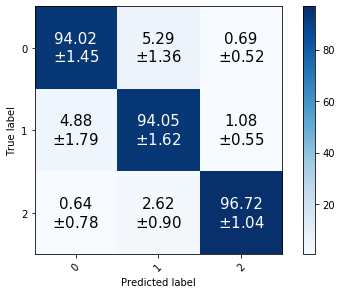

In [16]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
from operator import truediv
import h5py
import pickle
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, cohen_kappa_score, confusion_matrix
from tensorflow_model_optimization.sparsity import keras as sparsity


tf.keras.backend.set_image_data_format('channels_last')
tf.keras.backend.set_learning_phase(0)


"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Prepare lists to save metrics
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

windowSize = train_x.shape[1]
classes = 3
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
cvoa = []
cvaa = []
cvka = []
cvpre = []
cvrec = []
cvf1 = []


def AA_andEachClassAccuracy(confusion_m):
    list_diag = np.diag(confusion_m)
    list_raw_sum = np.sum(confusion_m, axis=1)
    each_ac = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_ac)
    return each_ac, average_acc


"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
PREDICT AND CALCULATE METRICS
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
loaded_model = tf.keras.models.load_model("selected5-weights-hyper3dnet" + 'WEED' + str(1) + "-best_3layers_4filters.h5")
epochs = 8
batch_size = 32;
num_train_samples = train_x.shape[0]
end_step = np.ceil(1.0 * num_train_samples / batch_size).astype(np.int32) * epochs
print(end_step)

dataset = 'WEED'
# Initialize
confmatrices = np.zeros((10, int(classes), int(classes)))

ntrain = 1
for train, test in kfold.split(train_x, train_y):
    ytest = tf.keras.utils.to_categorical(train_y[test]).astype(np.int32)

    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    PRUNING
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    new_pruning_params = {
          'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.10,
                                                      final_sparsity=0.30,
                                                      begin_step=0,
                                                      end_step=end_step,
                                                      frequency=100)
    }

    new_pruned_model = sparsity.prune_low_magnitude(loaded_model, **new_pruning_params)

    new_pruned_model.load_weights("pruned5-weights-hyper3dnet" + dataset + str(ntrain) + "-best_3layers_4filters.h5")
    ypred = new_pruned_model.predict(train_x[test])

    sess = tf.Session()
    with sess.as_default():
        con_mat = tf.math.confusion_matrix(labels=np.argmax(ytest, axis=-1),
                                           predictions=np.argmax(ypred, axis=-1)).numpy()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=3)
    classes_list = list(range(0, int(classes)))
    con_mat_df = pd.DataFrame(con_mat_norm, index=classes_list, columns=classes_list)

    confmatrices[ntrain - 1, :, :] = con_mat_df.values

    # Calculate metrics
    oa = accuracy_score(np.argmax(ytest, axis=1), np.argmax(ypred, axis=-1))
    confusion = confusion_matrix(np.argmax(ytest, axis=1), np.argmax(ypred, axis=-1))
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(ytest, axis=1), np.argmax(ypred, axis=-1))
    prec, rec, f1, support = precision_recall_fscore_support(np.argmax(ytest, axis=1), np.argmax(ypred, axis=-1),
                                                             average='macro')

    # Add metrics to the list
    cvoa.append(oa * 100)
    cvaa.append(aa * 100)
    cvka.append(kappa * 100)
    cvpre.append(prec * 100)
    cvrec.append(rec * 100)
    cvf1.append(f1 * 100)

    ntrain += 1

file_name = "classification_report_hyper3dnet_pruned5" + dataset + ".txt"
with open(file_name, 'w') as x_file:
    x_file.write("Overall accuracy%.3f%% (+/- %.3f%%)" % (float(np.mean(cvoa)), float(np.std(cvoa))))
    x_file.write('\n')
    x_file.write("Average accuracy%.3f%% (+/- %.3f%%)" % (float(np.mean(cvaa)), float(np.std(cvaa))))
    x_file.write('\n')
    x_file.write("Kappa accuracy%.3f%% (+/- %.3f%%)" % (float(np.mean(cvka)), float(np.std(cvka))))
    x_file.write('\n')
    x_file.write("Precision accuracy%.3f%% (+/- %.3f%%)" % (float(np.mean(cvpre)), float(np.std(cvpre))))
    x_file.write('\n')
    x_file.write("Recall accuracy%.3f%% (+/- %.3f%%)" % (float(np.mean(cvrec)), float(np.std(cvrec))))
    x_file.write('\n')
    x_file.write("F1 accuracy%.3f%% (+/- %.3f%%)" % (float(np.mean(cvf1)), float(np.std(cvf1))))

# Calculate mean and std
means = np.mean(confmatrices * 100, axis=0)
stds = np.std(confmatrices * 100, axis=0)

def plot_confusion_matrix(cm, cms, classescf,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classescf))
    plt.xticks(tick_marks, classescf, rotation=45)
    plt.yticks(tick_marks, classescf)

    thresh = cm.max() / 2.

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):

            if (cm[i, j] == 100 or cm[i, j] == 0) and cms[i, j] == 0:
                plt.text(j, i, '{0:.0f}'.format(cm[i, j]) + '\n$\pm$' + '{0:.0f}'.format(cms[i, j]),
                         horizontalalignment="center",
                         verticalalignment="center", fontsize=15,
                         color="white" if cm[i, j] > thresh else "black")

            else:
                plt.text(j, i, '{0:.2f}'.format(cm[i, j]) + '\n$\pm$' + '{0:.2f}'.format(cms[i, j]),
                         horizontalalignment="center",
                         verticalalignment="center", fontsize=15,
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

with open('meanshyper3dnet10p', 'wb') as f:
    pickle.dump(means, f)
with open('stdshyper3dnet10p', 'wb') as f:
    pickle.dump(stds, f)
with open('cvf1hyper3dnet10p', 'wb') as f:
    pickle.dump(cvf1, f)

# Plot non-normalized confusion matrix
classes_list = list(range(0, int(3)))
plt.figure()
plot_confusion_matrix(means, stds, classescf=classes_list)

plt.savefig('MatrixConfusion_WEEDhyper3dnet_pruned_6p.png', dpi=1200)